In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})

np.set_printoptions(threshold=sys.maxsize)

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# State tomography analysis functions

Measurement occurs along 9 axes, each of which can give one of 4 values:

ZZ, ZX, ZY, XZ, XX, XY, YZ, YX, YY -> {00, 01, 10, 11}

In [3]:
meas_order = np.array(['ZZ', 'ZX', 'ZY', 'XZ', 'XX', 'XY', 'YZ', 'YX', 'YY'])
calib_order = np.array(['gg', 'ge', 'eg', 'ee'])

## Getting rho from meas counts

First random helper method stuff for pauli matrices and dealing with the measurement order

In [4]:
def pauli(i): return [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()][i]

def s2i(s): # string to pauli matrix index
    return int(np.char.find('IXYZ', s))

def i2s(i): # pauli matrix index to string
    return 'IXYZ'[i]

def order(S12): # given 2 pauli matrix names, get the index at which that combo (or equivalent data) was measured
    assert S12[0] in 'IXYZ'
    assert S12[1] in 'IXYZ'
    # for the purposes of getting counts, measuring in I basis and Z basis are interchangeable
    if S12[0] == 'I': S12 = 'Z'+S12[1]
    if S12[1] == 'I': S12 = S12[0]+'Z'
    return np.argwhere(meas_order == S12)[0][0]
# print(order('II'))

In [5]:
"""
Define basis in to be used when doing MLE
"""
# 2 cardinal points on Bloch sphere for each measurement axis
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi = dict(Z=psiZ, X=psiX, Y=psiY)

psi_basis = [] # ordered in the same sequence as the n counts array (36 elements)
for S12 in meas_order:
    S1, S2 = S12
    psi1 = psi[S1]
    psi2 = psi[S2]
    psi_basis.append(qt.tensor(psi1[0], psi2[0])) # gg
    psi_basis.append(qt.tensor(psi1[0], psi2[1])) # ge
    psi_basis.append(qt.tensor(psi1[1], psi2[0])) # eg
    psi_basis.append(qt.tensor(psi1[1], psi2[1])) # ee

Convert single shot measurements into counts for each of the 9 measurement axes: 4x9=36 elements in the count array, then into the initial rho from experiment which will likely be unphysical.

In [6]:
"""
n should be length 4 array containing single shot counts of measuring 00, 01, 10, 11 for measurement along axes i, j
Converts n to Tij for use in the T^\dag T = rho matrix where measurement axes are S1 and S2: I, X, Y, Z
"""
def Tij(n, S1, S2):
    assert 0 <= S1 <= 3 # S1, S2 represent pauli matrix indices
    assert 0 <= S2 <= 3
    signs = [1]*4
    # eigenvalues of X, Y, Z are +/- 1, eigenvalues of I are +1
    if S1 > 0: signs[2] *= -1; signs[3] *= -1
    if S2 > 0: signs[1] *= -1; signs[3] *= -1
    return np.sum(np.multiply(signs, n))


In [7]:
"""
Construct rho by adding together Tij for each of the 4^2 = 16 combinations of tensor product of 2 Pauli matrices
"""
def rho_from_counts(n):
    rho = 0*qt.tensor(qt.qeye(2), qt.qeye(2))
    for i in range(4): # loop over pauli matrices for qubit 1
        for j in range(4): # loop over pauli matrices for qubit 2
            o = order(i2s(i) + i2s(j)) # get the right 4 elements in the n matrix
            # print(i2s(i), i2s(j), Tij(n[4*o:4*(o+1)], i, j))
            rho += Tij(n[4*o:4*(o+1)], i, j) * qt.tensor(pauli(i), pauli(j))
    rho = rho.unit() # normalize
    rho = rho.tidyup(1e-10) # remove small elements
    return rho.full()

### Generate test data

In [8]:
def generate_counts(rho_id, n_tot, noise=1.0):
    n = []
    for psi in psi_basis:
        # measure in psi basis
        n.append(n_tot * (psi * psi.dag() * rho_id).tr())
    n = np.reshape(np.array(n), (len(psi_basis)//4, 4))

    # introduce gaussian noise
    for n_psi in n:
        n_meas = sum(n_psi)
        new_n3 = -1
        while new_n3 < 0:
            new_n012 = np.random.normal(loc=n_psi[:3], scale=noise*np.sqrt(n_psi[:3]))
            # preserve original total count per measurement
            new_n3 = n_meas - sum(new_n012)
        n_psi[:3] = np.round(new_n012)
        n_psi[3] = np.round(new_n3)
    return n

### Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

maybe need to do something about fixing negative counts, but for now I will not. it should be automatically resolved in the MLE.

In [9]:
def correct_readout_err(n, n_conf):
    conf_mat = np.array(n_conf, dtype=float)
    for r, row in enumerate(conf_mat):
        conf_mat[r] /= sum(row) # normalize so counts for each state prep sum to 1
    conf_mat = np.transpose(conf_mat) # want counts for each state prep on columns
    conf_mat_inv = np.linalg.inv(conf_mat)
    # C_id = invM . C_noisy
    n = np.array(n, dtype=float)
    for r in range(len(n)):
        n[r] = (conf_mat_inv @ n[r].T).T
    return np.around(n, decimals=5)

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions

In [10]:
# Modification of np.diag_indices to allow off diagonal entries
# n = dim, k < 0 = lower diagonals, k > 0 = upper diagonals
def diag_indices_k(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0: return rows[-k:], cols[:k]
    elif k > 0: return rows[:-k], cols[k:]
    else: return rows, cols

def T_flat2mat(t):
    # T_mat = []
    # T_mat.appen(np.array([t[0],           0,              0,               0]))
    # T_mat.append(np.array([t[4] +1j*t[5],  t[1],           0,               0]))
    # T_mat.append(np.array([t[10]+1j*t[11], t[6]+1j*t[7],   t[2],            0]))
    # T_mat.append(np.array([t[14]+1j*t[15], t[12]+1j*t[13], t[8]+1j*t[9], t[3]]))
    d = int(np.sqrt(len(t)))
    t_complex = np.zeros(int(d + (len(t)-d)/2), dtype=complex)
    t_complex[:d] = t[:d]
    for i in range(d, len(t_complex)):
        t_complex[i] = t[d + (i-d)*2] + 1j*t[d + (i-d)*2 + 1]
    T_mat = np.zeros(shape=(d,d), dtype=complex)
    start_i = 0
    for k in range(d):
        T_mat[diag_indices_k(T_mat, -k)] = t_complex[start_i:start_i+(d-k)]
        start_i += d - k
    return np.array(T_mat)


Not using these!


This is taken from [James et al. 2001](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.052312), eq. 4.6.

In [11]:
# def det_ij(rho, i, j):
#     M = np.delete(rho, i, axis=0)
#     M = np.delete(M, j, axis=1)
#     return np.linalg.det(M)

# def det_ijkl(rho, i, j, k, l):
#     M = np.delete(rho, [i,k], axis=0)
#     M = np.delete(M, [j,l], axis=1)
#     return np.linalg.det(M)

# def t_from_rho_unused(rho):
#     t = []
#     det = np.linalg.det(rho)
#     det00 = det_ij(rho, 0, 0)
#     det01 = det_ij(rho, 0, 1)
#     det0011 = det_ijkl(rho, 0, 0, 1, 1)
#     det0012 = det_ijkl(rho, 0, 0, 1, 2)
#     det0112 = det_ijkl(rho, 0, 1, 1, 2)
#     # ensure no divide by 0 errors since this algo is intended for positive definite matrices
#     if det == 0: det = 1e-10
#     if det00 == 0: det00 = 1e-10
#     if det0011 == 0: det0011 = 1e-10
#     if det0012 == 0: det0012 = 1e-10
#     if det0112 == 0: det0112 = 1e-10
#     rho33 = rho[3,3]
#     if rho33 == 0: rho33 = 1e-10
#     t = [np.sqrt(det/det00), np.sqrt(det00/det0011), np.sqrt(det0011/rho33), np.sqrt(rho[3,3])]
#     t56 = det01/np.sqrt(det00*det0011)
#     t.extend([np.real(t56), np.imag(t56)])
#     t78 = det0012/np.sqrt(rho33*det0011)
#     t.extend([np.real(t78), np.imag(t78)])
#     t910 = rho[3,2]/np.sqrt(rho33)
#     t.extend([np.real(t910), np.imag(t910)])
#     t1112 = det0112/np.sqrt(rho33*det0011)
#     t.extend([np.real(t1112), np.imag(t1112)])
#     t1314 = rho[3,1]/np.sqrt(rho33)
#     t.extend([np.real(t1314), np.imag(t1314)])
#     t1516 = rho[3,0]/np.sqrt(rho33)
#     t.extend([np.real(t1516), np.imag(t1516)])
#     assert(len(t)==16)
#     return np.real(np.array(t)) # take the real since rho may be slightly non-positive semi definite, so det(rho) may be slightly negative

# def rho_from_t_unused(t):
#     T = T_flat2mat(t)
#     rho = T.conj().T @ T
#     return rho / np.trace(rho)

Using this.

Cholesky-Banachiewicz algorithm - valid for positive definite matrices, so need to ensure no divide by 0 errors. I think this actually works better than the James et al method?

In [12]:
def t_from_rho(rho):
    t = []
    T = np.zeros(shape=np.shape(rho))
    d = np.shape(rho)[0]
    for i in range(d):
        for j in range(i+1):
            sum = 0
            for k in range(j):
                sum += T[i, k] * T[j, k]
            if i == j: T[i, i] = np.sqrt(rho[i, i] - sum)
            else:
                Tjj = T[j, j]
                if Tjj == 0: Tjj = 1e-10
                T[i, j] = (rho[i, j] - sum) / Tjj
    t = np.diagonal(T)
    for k in range(1, d):
        t_complex = np.diag(T, k=-k)
        for t_i in t_complex:
            t = np.append(t, [np.real(t_i), np.imag(t_i)])
    assert(len(t)==16)
    return np.real(t)
    
def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T @ T.conj().T
    return rho / np.trace(rho)

### ZZ correction
Instead of using bare psis in MLE, introduce ZZ coupling in Hamiltonian and use the pulse shapes used in the tomography pulse sequence to simulate the expected final state of each of the psis. Then use these corrected "evolution matrices" to match the MLE.

Note: uses QSwitch and related classes

In [13]:
"""
Convert dac units to drive strength in GHz
"""
def gain_to_freq(dac_units):
    # raise NotImplementedError
    return dac_units/32000
    
def get_evoln_mats(qfreqs, alphas, gs, pulse_dict):
    assert len(pulse_dict.items()) == len(meas_order)
    print("WARNING: current gain to freq conversion for rfsoc is very fake!", flush=True)
    evoln_mats = dict()
    for pulse, pulse_cfg in tqdm(pulse_dict.items()):
        # print(pulse)
        device = QSwitch(qubit_freqs=qfreqs, alphas=alphas, gs=gs, cutoffs=[2,2], is2Q=True)
        seq = PulseSequence()
        q0_params = pulse_cfg[f'qubit{qubits[0]}'].copy()
        q1_params = pulse_cfg[f'qubit{qubits[1]}'].copy()

        t_offset = 0
        for params in (q0_params, q1_params):
            params['freq'] = soc.reg2freq(params['freq'], gen_ch=params['ch']) * 1e-3
            params['gain'] = gain_to_freq(params['gain'])
            params['phase'] = soc.reg2deg(params['phase']) * np.pi/180
            type = params['type']
            total_length = 0
            if type == 'const':
                params['length'] = soc.cycles2us(params['length']) * 1e3
                total_length = params['length']
            elif type == 'gauss': 
                params['sigma'] = soc.cycles2us(params['sigma']) * 1e3
                total_length = 4*params['sigma']
            elif type == 'flat_top':
                raise NotImplementedError
                params['sigma'] = soc.cycles2us(params['sigma']) * 1e3
                params['flat_length'] = soc.cycles2us(params['flat_length']) * 1e3
                total_length = None
            device.add_precise_pi_pulse(seq, 'gg', 'ee', amp=params['gain'], drive_qubit=1, wd=params['freq'], phase=params['phase'], type=type, t_offset=t_offset, t_pulse=total_length)
            # t_offset = -total_length # play the pulses on the two qubits at the same time
        pulse_index = np.where(np.array(meas_order)==str(pulse))[0][0]
        psi0 = psi_basis[pulse_index]
        times = np.linspace(0, total_length+10)
        evoln_mats.update({pulse:device.evolve(psi0, seq, times, nsteps=10000, use_str_solve=False, progress=False)[-1]})
    evoln_mats_in_meas_order = []
    for pulse in meas_order: evoln_mats_in_meas_order.append(evoln_mats[pulse])
    return evoln_mats_in_meas_order

### MLE functions

In [14]:
def run_MLE_standard(n, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return np.log(val)
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [15]:
def run_MLE_ZZ(n, evol_matrices, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(evol_matrices, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return np.log(val)
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [16]:
def run_MLE(n, ZZ_correction=False, evol_matrices=None, rho_guess=None, method='L-BFGS-B'):
    if ZZ_correction: return run_MLE_ZZ(n, evol_matrices, rho_guess=rho_guess, method=method)
    else: return run_MLE_standard(n, rho_guess=rho_guess, method=method)

# Plotting functions

In [17]:
def show_mat_2d(mat, ax, title, labels, cmax=None, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    plt.xticks(np.arange(len(mat)), labels)
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-1, vmax=1)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None, title=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    labels = ["00", "01", "10", "11"]
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 12))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title)
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, show=False)
    plt.show()

In [18]:
# Author: Ziqian
def show_plot_rho_3d(rho_MLE, rho_id=None):
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
    else:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')
        ax3 = fig.add_subplot(223, projection='3d')
        ax4 = fig.add_subplot(224, projection='3d')
    
    labels = ["00", "01", "10", "11"]
    qplt.matrix_histogram(np.real(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax1)
    qplt.matrix_histogram(np.imag(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax2)
    if rho_id is not None:
        qplt.matrix_histogram(np.real(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax3)
        qplt.matrix_histogram(np.imag(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax4)
    
    ax1.view_init(azim=-55, elev=45)
    ax2.view_init(azim=-55, elev=45)
    ax1.set_title("Re[$\\rho_{MLE}$]")
    ax2.set_title("Im[$\\rho_{MLE}$]")
    if rho_id is not None:
        ax3.view_init(azim=-55, elev=45)
        ax4.view_init(azim=-55, elev=45)
        ax3.set_title("Re[$\\rho_{ideal}$]")
        ax4.set_title("Im[$\\rho_{ideal}$]")
    plt.show()

# Run experiment and analysis

In [19]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
i

In [20]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [21]:
# expt_path = os.getcwd()+'\data'
# expt_path = 's:\\Connie\\experiments\\20220430_2Transmon\\data'
expt_path = os.getcwd()+'\\data_220712'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data_220712


In [22]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file

# config_file = 'config.yml'
# config_path = 's:\\Connie\\experiments\\20220430_2Transmon\\' + config_file

print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


In [23]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [24]:
qubits = [2, 1] # which qubit/resonator we want to probe

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [25]:
im = InstrumentManager()

In [27]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

0

In [26]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, switch ch -1, maxlen 0
		DAC tile 0,

## Run experiment and acquire data

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 456.7], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 15419, 13869, 7000], 'sigma': [0.035, 0.025, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 10922, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 10000], 'sigma': [0.1, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -804.7555447534925, -82.3, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.07, 0.04, 0.07], 'phase': [0, 0, 90, 0], 'threshold_ge': [0, -73, 0.75, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [10, 10, 10, 10], 'relax_delay': [200, 300, 150, 50]}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 

  0%|          | 0/4 [00:00<?, ?it/s]

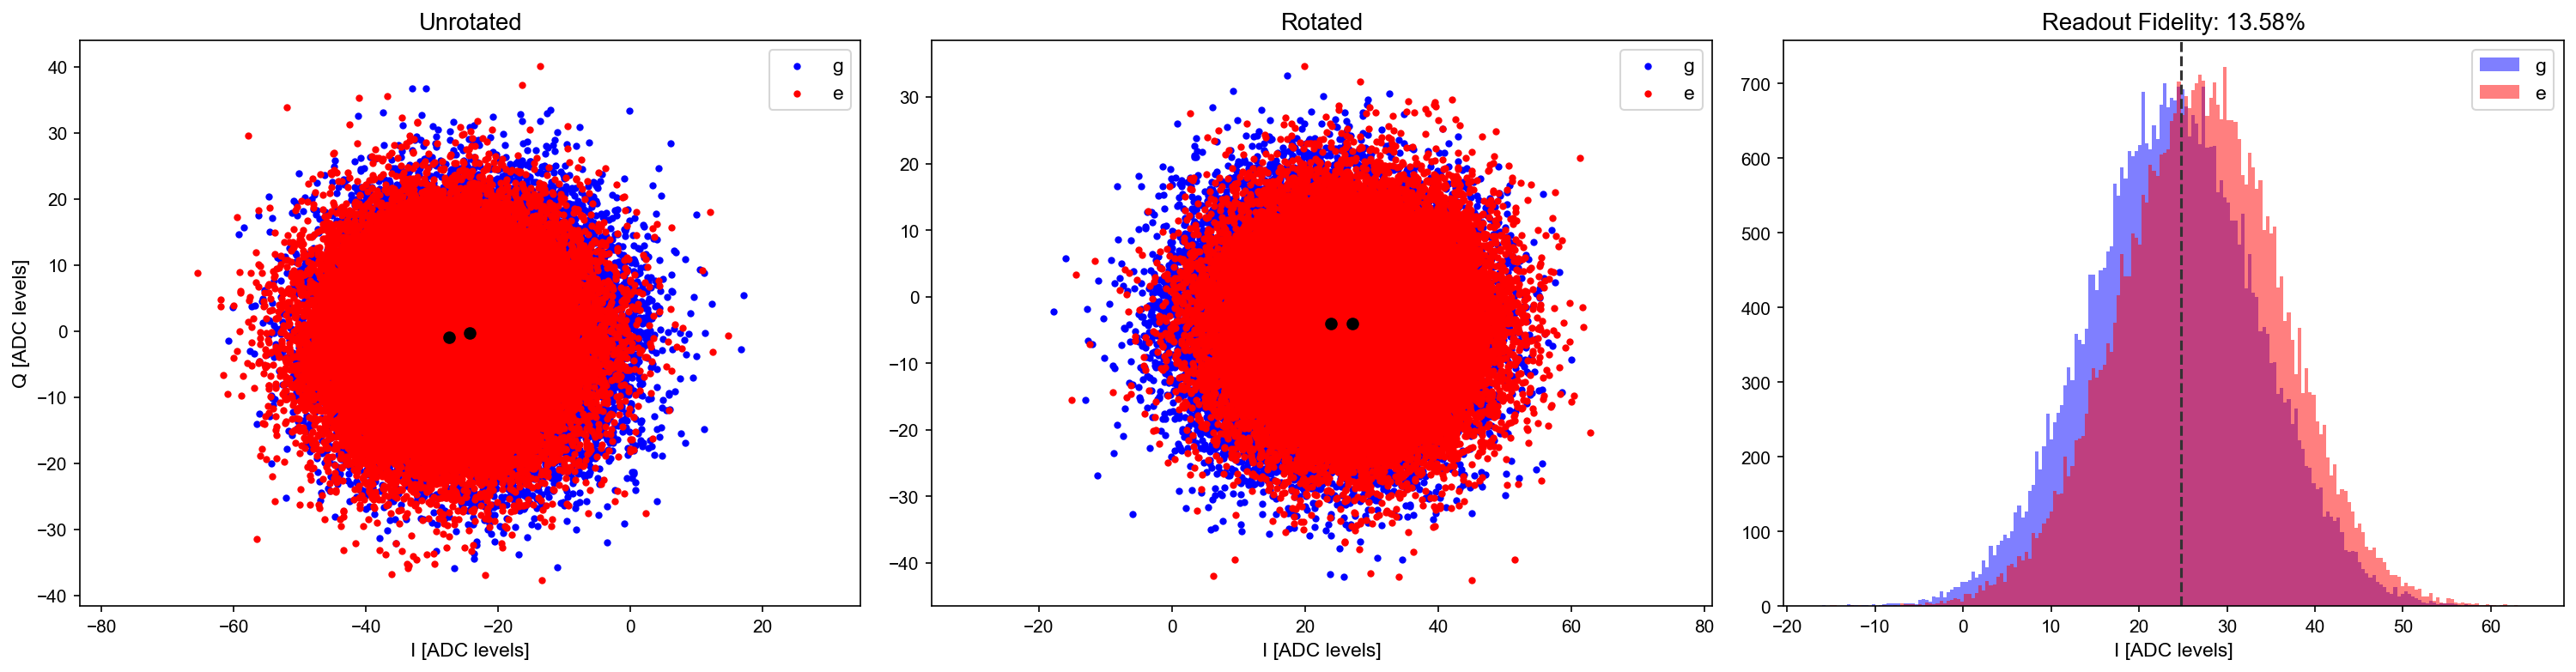

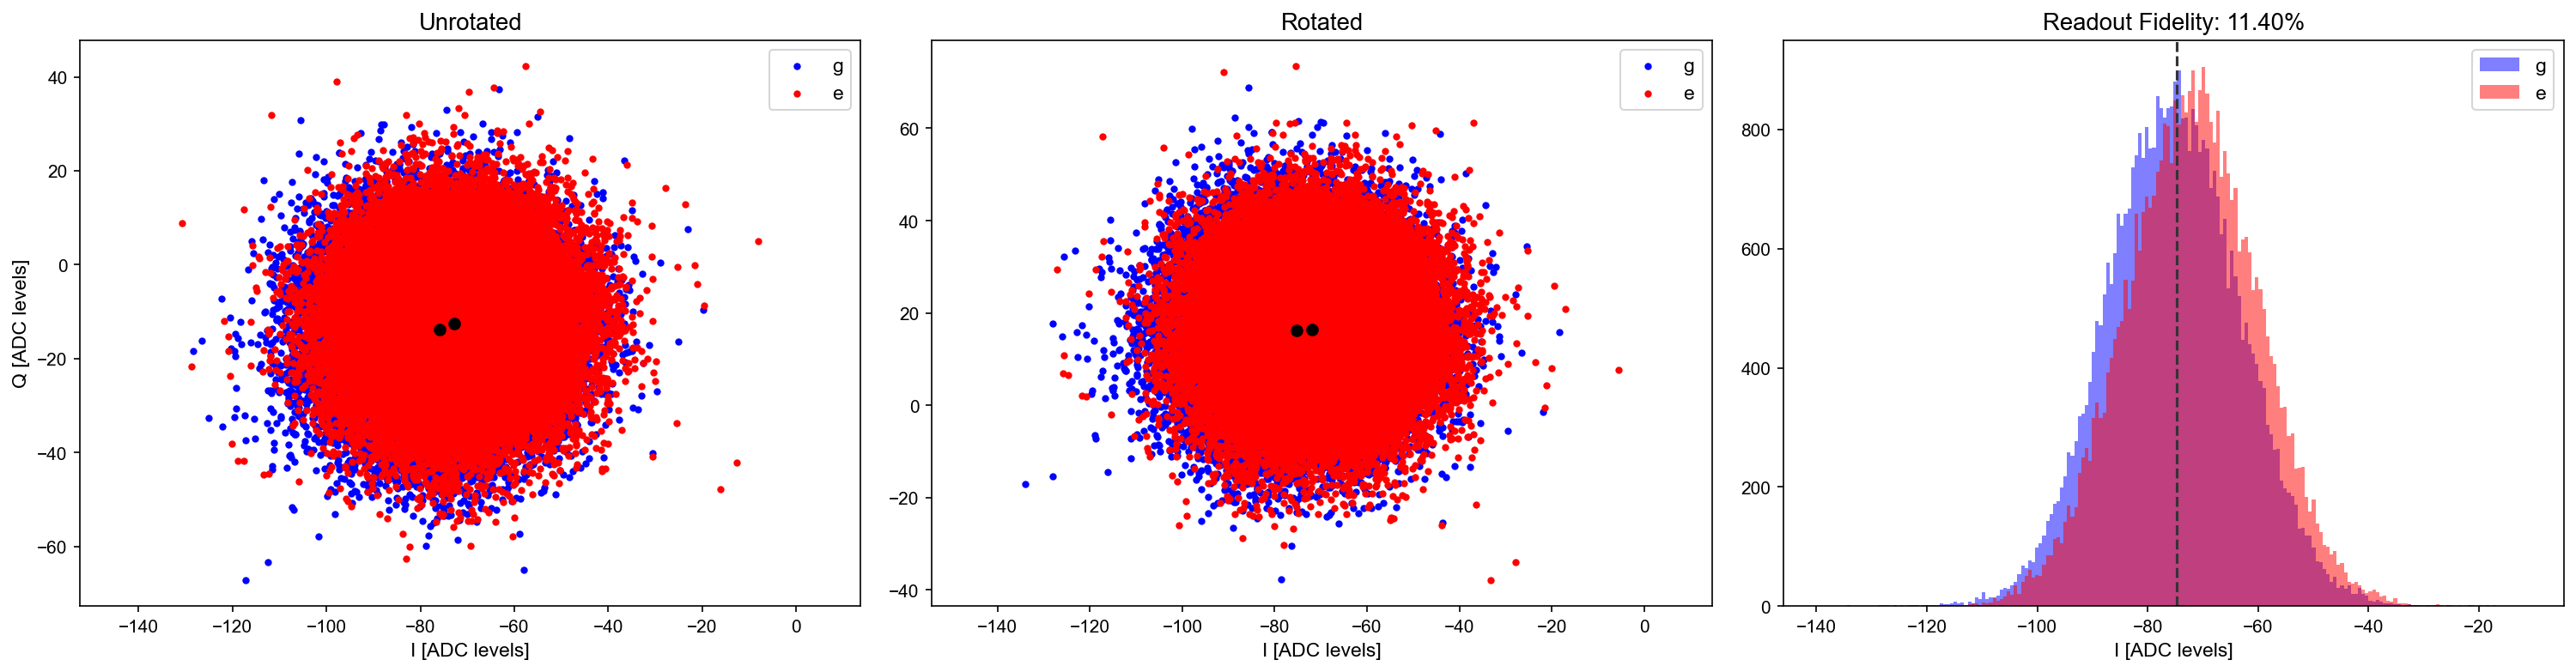

thresholds [0, -74.68953063558958, 24.727929335315537, 0]
angles [0, -22.532864962573544, 169.61715869211392, 0]
[-0.3786853237878295, -75.2288630221951, 23.94103509683842, -0.5339733159778717]
[-0.47927107061503416, -71.9806953213647, 26.15184117428276, -0.6041490400260332]
[-0.4443215099251546, -75.11420404164576, 27.019335797418456, -0.5559713634884478]
[-0.583257403189066, -72.44145387599704, 27.60361772178365, -0.45387243735763094]


  0%|          | 0/9 [00:00<?, ?it/s]

[-0.458623494956069, -74.02823112652607, 26.912571977999725, -0.4593068662544745]
[-0.47753010087862025, -73.74313520993911, 26.9082951001691, -0.5612756264236902]
[-0.5844126260982754, -73.85302043586557, 26.666880550858636, -0.4990888382687927]
[-0.5549625772860396, -74.05618500429597, 26.02731852567774, -0.5360071591278881]
[-0.47731858119101855, -73.42238408392467, 26.21126430195411, -0.5398470549951189]
[-0.410380735437683, -73.42466010796467, 26.0747696009564, -0.4878945655711032]
[-0.5273511226814188, -74.04620058345479, 25.982928805360782, -0.5112268141880898]
[-0.530621542466645, -73.3580259396631, 26.078348298574333, -0.42398307842499194]
[-0.5079726651480638, -73.33242317981554, 26.255231065496645, -0.6052066384640417]


In [62]:
tomo = meas.EgGfStateTomographyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGf_state_tomo_{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

tomo.cfg.expt = dict(
    reps=40000, # reps per measurement basis
    shot_avg=10, # number of shots to average over before sorting via threshold
    qubits=qubits,
)

print(tomo.cfg)
tomo.go(analyze=False, display=False, progress=True, save=False)

In [64]:
# data, attrs = prev_data(expt_path, '00000_EgGf_state_tomo_01.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == meas_order)
assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

print('Tomography counts')
print(n_tomo)
print('Confusion matrix counts')
print(n_calib)
print('Corrected tomo matrix will be')
print(correct_readout_err(n_tomo, n_calib))

Tomography counts
[[ 404  498 1338 1760]
 [ 395  571 1237 1797]
 [ 417  610 1281 1692]
 [ 580  744 1146 1530]
 [ 496  722  988 1794]
 [ 509  795 1012 1684]
 [ 583  761 1161 1495]
 [ 474  849  970 1707]
 [ 466  785  972 1777]]
Confusion matrix counts
[[1384 1015  863  738]
 [ 311  969  670 2050]
 [ 500  378 1669 1453]
 [ 185  508  928 2379]]
Corrected tomo matrix will be
[[  40.61079  547.44422 2407.39583 1004.54916]
 [  51.59658 1066.22982 2043.78012  838.39347]
 [ -46.48713 1632.66299 2469.91281  -56.08867]
 [ 621.18619 1898.13526 1892.16734 -411.48879]
 [ 669.19907 1362.52671  856.99033 1111.28389]
 [ 495.89751 2311.99693 1301.92786 -109.8223 ]
 [ 559.832   2160.15976 2058.98826 -778.98002]
 [ 311.5627  2980.40533 1291.76269 -583.73073]
 [ 426.7458  2230.69831 1051.63109  290.9248 ]]


## Run analysis

Generate test data

In [65]:
# n_tomo = generate_counts(rho_id=rho_id, n_tot=1000, noise=1)
# print(n_tomo)

Calculate ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [66]:
# psi_id = qt.tensor(psiZ[0], 1/np.sqrt(2)*(psiZ[0]+psiZ[1]))
# psi_id = qt.tensor(psiZ[1], psiZ[1])
psi_id = qt.tensor(psiZ[0], psiZ[1])

rho_id = qt.ket2dm(psi_id)
print(rho_id)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


##### Run MLE without ZZ correction

In [67]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE_base = run_MLE(correct_readout_err(n_tomo, n_calib), ZZ_correction=False, method='L-BFGS-B')
if rho_MLE_base is not None:
    fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
    print(f'Fidelity (no ZZ correction): {fid_base}')
    print(f'Purity (no ZZ correction): {purity_base}')

 <ipython-input-12-6a6b3d84e3f8>: 10ComplexWarning: Casting complex values to real discards the imaginary part
 <ipython-input-12-6a6b3d84e3f8>: 14

Convergence: True
Fidelity (no ZZ correction): 0.14418379099999998
Purity (no ZZ correction): 0.5871763985624946


In [68]:
print(np.around(rho_MLE_base, decimals=3))

[[ 0.189+0.j    -0.077+0.146j -0.051+0.018j  0.05 +0.225j]
 [-0.077-0.146j  0.144+0.j     0.035+0.032j  0.153-0.131j]
 [-0.051-0.018j  0.035-0.032j  0.356+0.j     0.023-0.164j]
 [ 0.05 -0.225j  0.153+0.131j  0.023+0.164j  0.311+0.j   ]]


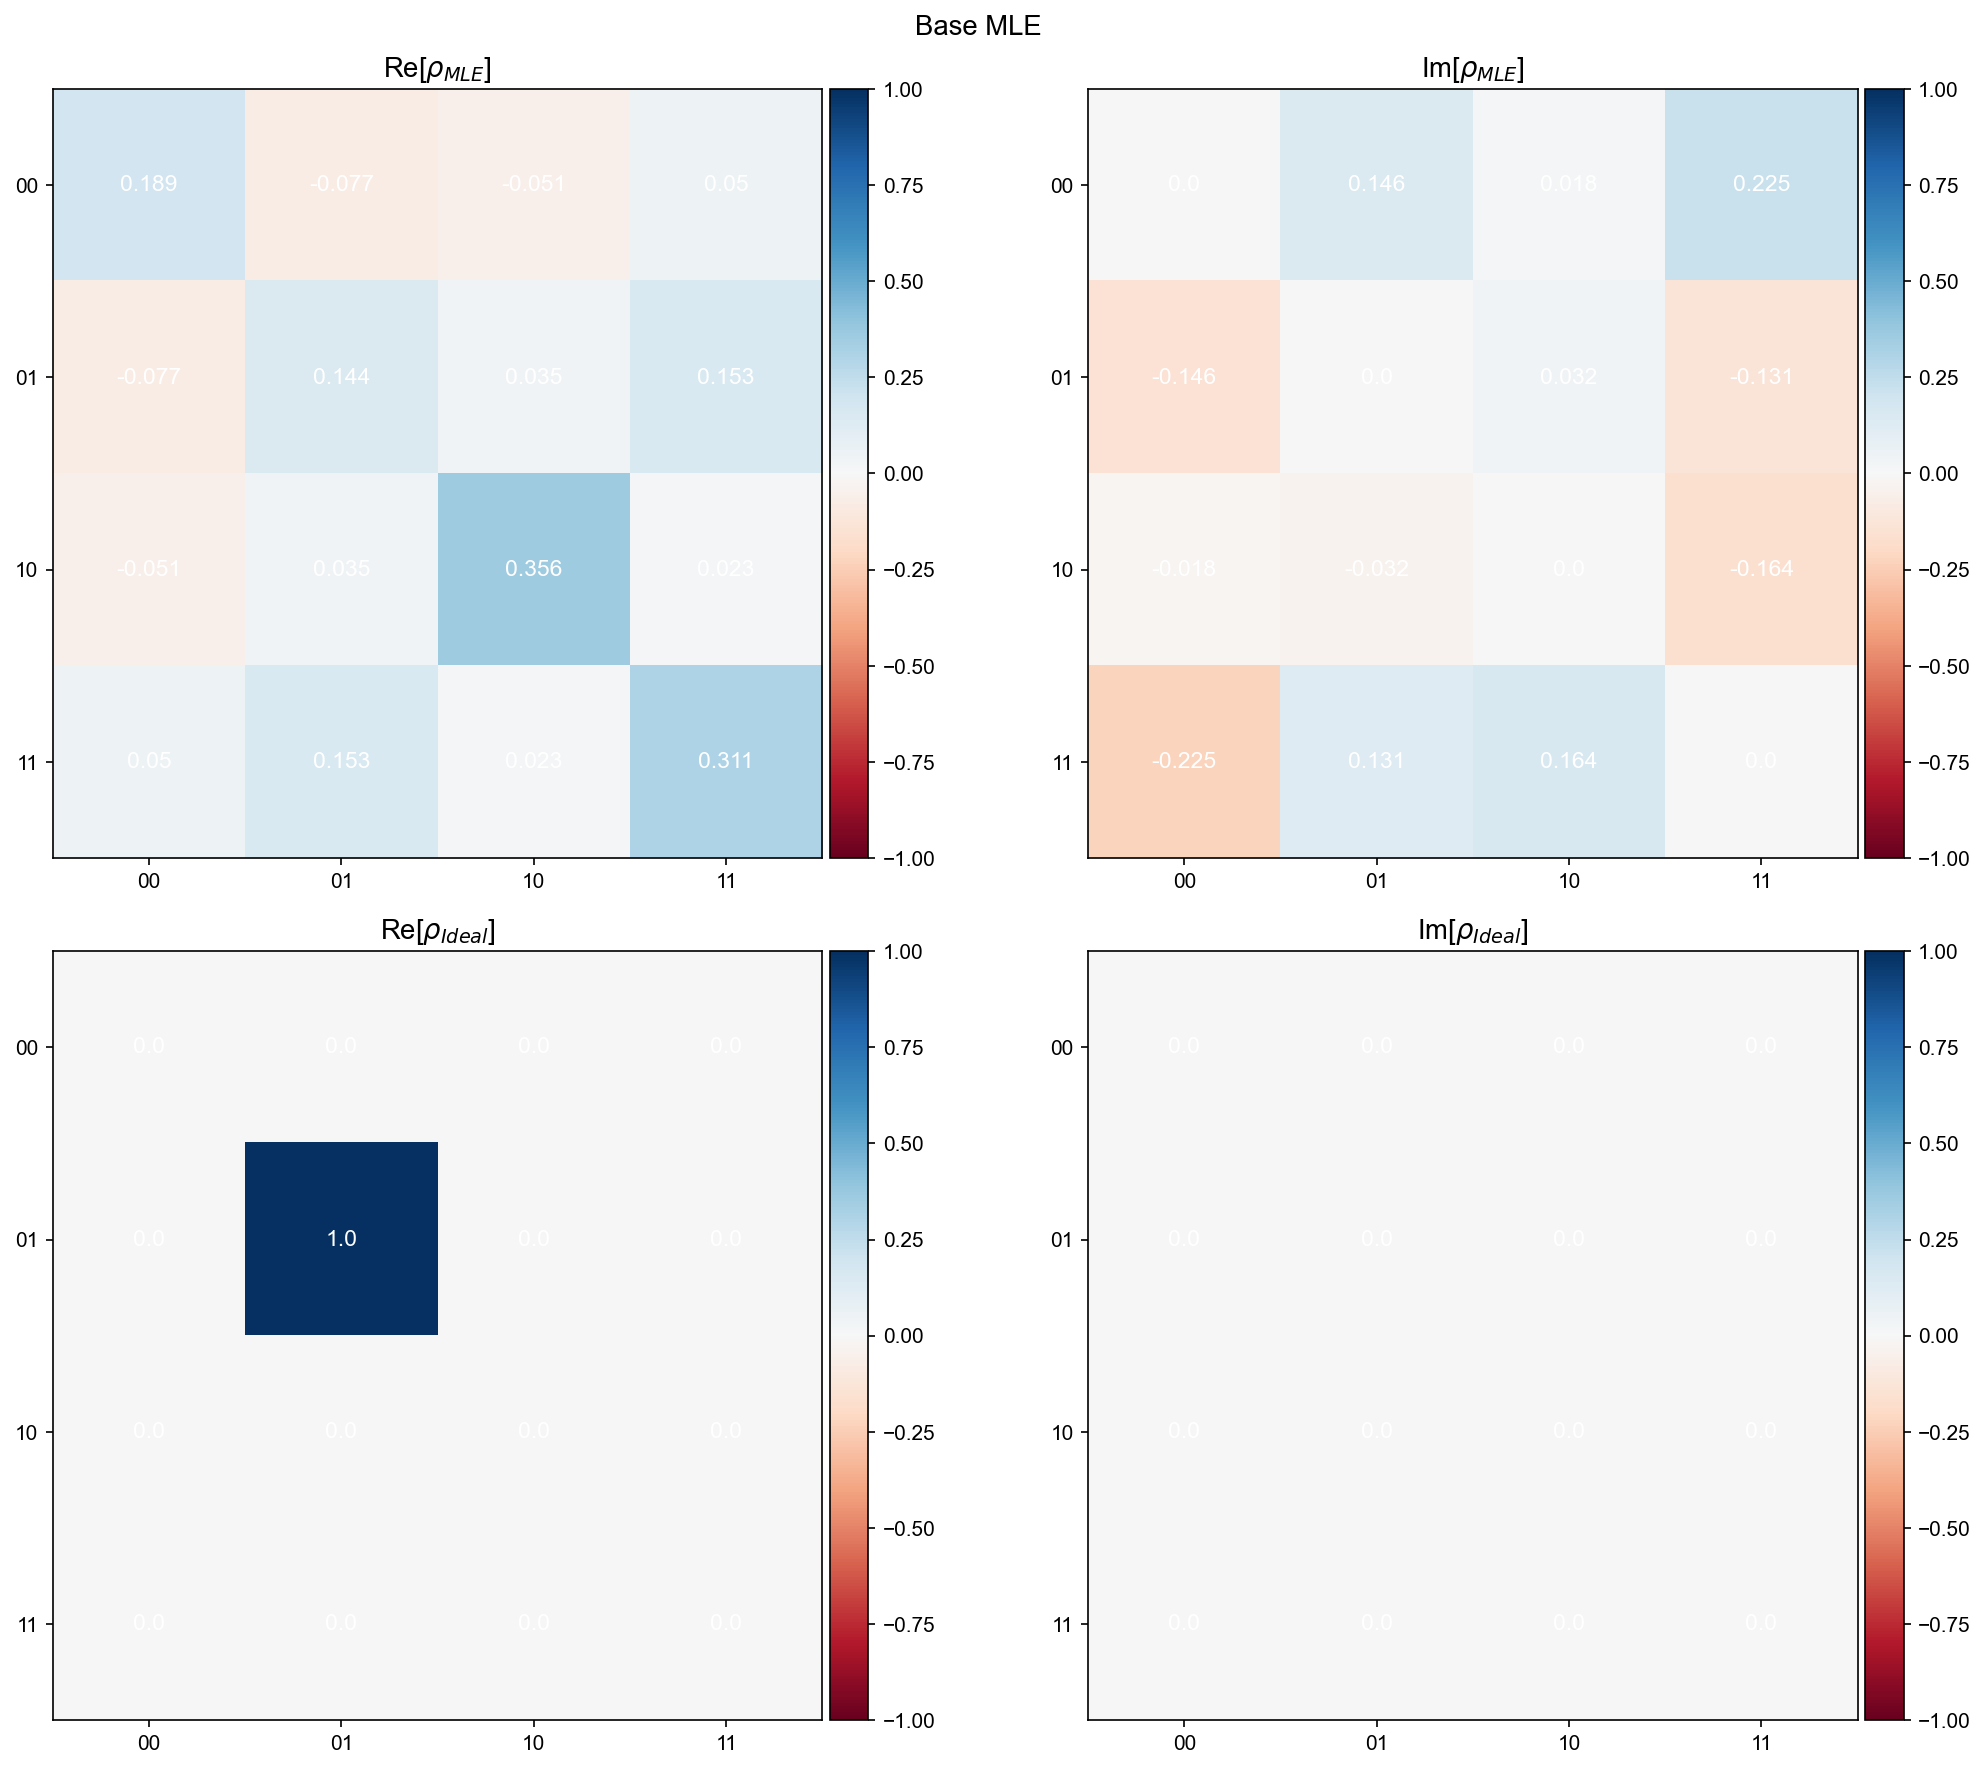

In [69]:
show_plot_rho_2d(rho_MLE_base, rho_id, title='Base MLE')

#### Run MLE with ZZ

Get evoln matrices for ZZ

In [72]:
qfreqs = np.array(yaml_cfg.device.qubit.f_ge) # MHz
alphas = np.array(yaml_cfg.device.qubit.f_ef) - qfreqs # MHz
g = 25 # MHz
evol_matrices = get_evoln_mats(qfreqs=qfreqs*1e-3, alphas=alphas*1e-3, gs=g*1e-3, pulse_dict=pulse_dict)

100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


In [73]:
rho_MLE_ZZ = run_MLE(correct_readout_err(n_tomo, n_calib), rho_guess=None, ZZ_correction=True, evol_matrices=evol_matrices)
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')

 <ipython-input-12-6a6b3d84e3f8>: 10ComplexWarning: Casting complex values to real discards the imaginary part
 <ipython-input-12-6a6b3d84e3f8>: 14

Convergence: True
Fidelity (with ZZ correction): 0.13812282157831718
Purity (with ZZ correction): 0.5934156712382259


In [74]:
print(np.around(rho_MLE_ZZ, decimals=3))

[[0.104+0.j    0.1  +0.066j 0.175+0.058j 0.06 -0.061j]
 [0.1  -0.066j 0.138+0.j    0.205-0.055j 0.019-0.097j]
 [0.175-0.058j 0.205+0.055j 0.327+0.j    0.069-0.142j]
 [0.06 +0.061j 0.019+0.097j 0.069+0.142j 0.431+0.j   ]]


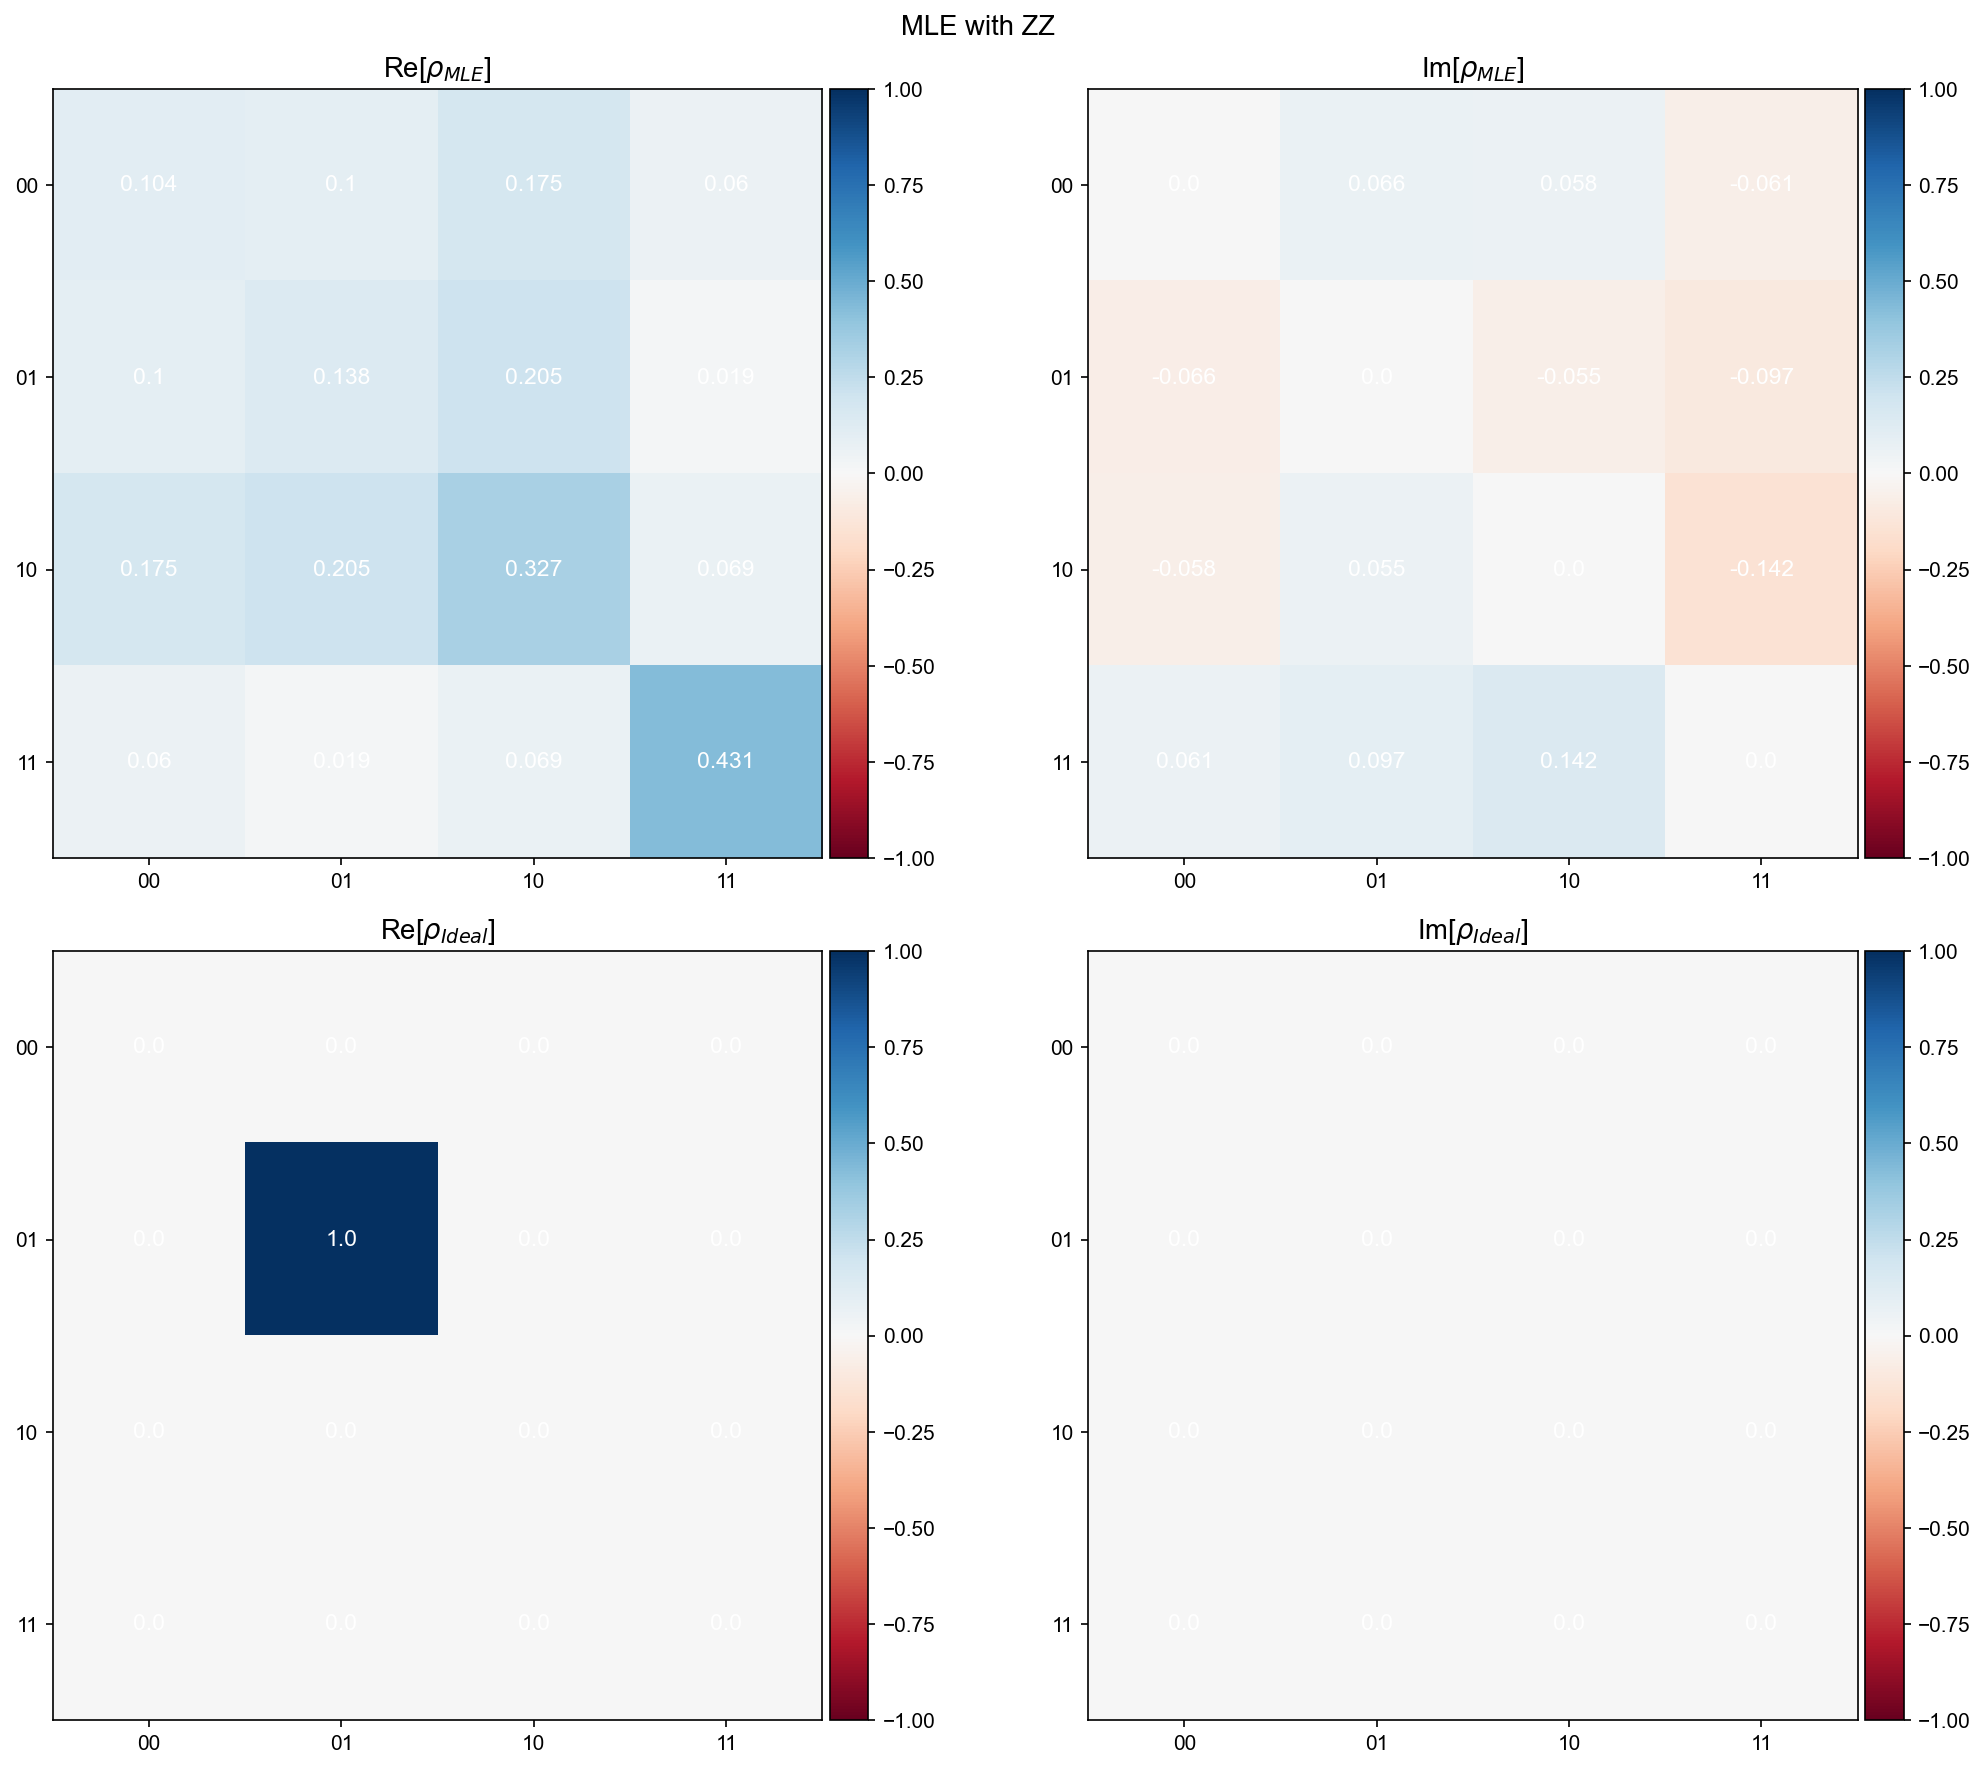

In [75]:
show_plot_rho_2d(rho_MLE_ZZ, rho_id, title='MLE with ZZ')

In [61]:
tomo.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00001_EgGf_state_tomo_21.h5
